<a href="https://colab.research.google.com/github/semthedev/OpenCV-projects/blob/main/lab_04_MediaPipe.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Обнаружение лиц с использованием MediaPipe Tasks/ Face Detection using MadiaPipe Tasks

This project is a demonstration of a face detection system leveraging the MediaPipe Tasks library. Its primary objective is to detect faces in images and visualize the detection results effectively.

Key Stages and Components:


1.   Installation and Setup:
The project begins by installing the MediaPipe library and downloading a pre-trained BlazeFace model, which is then saved locally. This setup ensures that the model is readily available for inference.
2.   Importing Required Libraries:
Essential libraries such as OpenCV for image processing, NumPy for numerical operations, and Python’s built-in modules for mathematical calculations and type annotations are imported. MediaPipe’s various submodules, especially for vision tasks, are also utilized.
3.   Utility Functions:
A helper function, _normalized_to_pixel_coordinates, converts normalized coordinates (ranging from 0 to 1) into actual pixel values. This conversion is crucial for accurately mapping the detection results onto the image.
4.   Visualization:
The visualize function processes the detection results by drawing bounding boxes around detected faces, plotting keypoints, and annotating the image with labels and detection probabilities. This makes it easy to verify the performance of the face detector visually.
5.   Image Acquisition and Processing:
The project retrieves a sample image from the internet using a curl command. The image is then read, displayed, and processed using OpenCV. MediaPipe is employed to convert the image into a suitable format for the face detector.
6.   Face Detection:
A face detector object is created using the downloaded BlazeFace model. The detector processes the input image and outputs detection results that include the bounding box coordinates and related metadata for each detected face.
7.   Displaying the Results:
The final step involves overlaying the detection results on the original image. The annotated image—with bounding boxes, keypoints, and labels—is then displayed to provide a clear visualization of the face detection process.





In [48]:
# Устанавливаем библиотеку mediapipe
!pip install mediapipe

In [49]:
# Импортируем необходимые модули из mediapipe:
import mediapipe as mp                              # - mediapipe: основной модуль для работы с компьютерным зрением
from mediapipe.tasks import python                  # - python и его подмодули: для задач компьютерного зрения
from mediapipe.tasks.python import vision


In [50]:
# Загружаем модель детектора лиц BlazeFace и сохраняем её в файл 'detector.tflite'
!wget -q -O detector.tflite -q https://storage.googleapis.com/mediapipe-models/face_detector/blaze_face_short_range/float16/1/blaze_face_short_range.tflite

In [51]:
# Импорт необходимых библиотек и типов:
# - math для математических операций,
# - cv2 (OpenCV) для работы с изображениями,
# - numpy для работы с массивами,
# - typing для указания типов.
from typing import Tuple, Union
import math
import cv2
import numpy as np

In [52]:
# Определяем параметры для отрисовки результатов:
MARGIN = 10         # Отступ от края изображения в пикселях
ROW_SIZE = 10       # Размер строки для размещения текста
FONT_SIZE = 1       # Размер шрифта для аннотаций
FONT_THICKNESS = 1  # Толщина шрифта
TEXT_COLOR = (255, 0, 0)  # Цвет текста (красный)

In [53]:
# Функция для преобразования нормализованных координат (значения от 0 до 1)
# в пиксельные координаты с учетом размеров изображения.
def _normalized_to_pixel_coordinates(
    normalized_x: float, normalized_y: float, image_width: int,
    image_height: int) -> Union[None, Tuple[int, int]]:
  """Преобразует нормализованные координаты в координаты пикселей.

  Аргументы:
    normalized_x: Нормализованная координата по оси X (от 0 до 1).
    normalized_y: Нормализованная координата по оси Y (от 0 до 1).
    image_width: Ширина изображения.
    image_height: Высота изображения.

  Возвращает:
    Кортеж (x, y) с координатами пикселей или None, если координаты вне диапазона.
  """

  # Вспомогательная функция для проверки, что значение находится в диапазоне [0, 1].
  def is_valid_normalized_value(value: float) -> bool:
    return (value > 0 or math.isclose(0, value)) and (value < 1 or math.isclose(1, value))

  # Если одно из значений не является допустимым, возвращаем None.
  if not (is_valid_normalized_value(normalized_x) and
          is_valid_normalized_value(normalized_y)):
    # TODO: Можно добавить обработку координат, выходящих за пределы изображения.
    return None

  # Перевод нормализованных координат в пиксели, учитывая размеры изображения.
  x_px = min(math.floor(normalized_x * image_width), image_width - 1)
  y_px = min(math.floor(normalized_y * image_height), image_height - 1)
  return x_px, y_px

In [54]:
# Функция для визуализации результатов детекции:
# Рисует прямоугольники вокруг обнаруженных лиц, отмечает ключевые точки и подписывает их.
def visualize(
    image,
    detection_result
) -> np.ndarray:
  """Рисует bounding boxes, ключевые точки и текстовые метки на изображении.

  Аргументы:
    image: Исходное изображение в формате RGB.
    detection_result: Результат детекции, содержащий список объектов Detection.

  Возвращает:
    Изображение с нанесенными аннотациями.
  """
  # Создаем копию исходного изображения для нанесения аннотаций.
  annotated_image = image.copy()
  height, width, _ = image.shape

  # Обрабатываем каждый обнаруженный объект (лицо).
  for detection in detection_result.detections:
    # Рисуем прямоугольник (bounding box), ограничивающий лицо.
    bbox = detection.bounding_box
    start_point = bbox.origin_x, bbox.origin_y
    end_point = bbox.origin_x + bbox.width, bbox.origin_y + bbox.height
    cv2.rectangle(annotated_image, start_point, end_point, TEXT_COLOR, 3)

    # Рисуем ключевые точки лица.
    for keypoint in detection.keypoints:
      keypoint_px = _normalized_to_pixel_coordinates(keypoint.x, keypoint.y,
                                                     width, height)
      # Определяем цвет (зеленый), толщину линии и радиус для отрисовки ключевых точек.
      color, thickness, radius = (0, 255, 0), 2, 2
      cv2.circle(annotated_image, keypoint_px, thickness, color, radius)

    # Формируем текстовую метку с названием категории и вероятностью.
    category = detection.categories[0]
    category_name = category.category_name
    category_name = '' if category_name is None else category_name
    probability = round(category.score, 2)
    result_text = category_name + ' (' + str(probability) + ')'

    # Определяем позицию для вывода текста на изображении.
    text_location = (MARGIN + bbox.origin_x,
                     MARGIN + ROW_SIZE + bbox.origin_y)
    cv2.putText(annotated_image, result_text, text_location, cv2.FONT_HERSHEY_PLAIN,
                FONT_SIZE, TEXT_COLOR, FONT_THICKNESS)

  return annotated_image

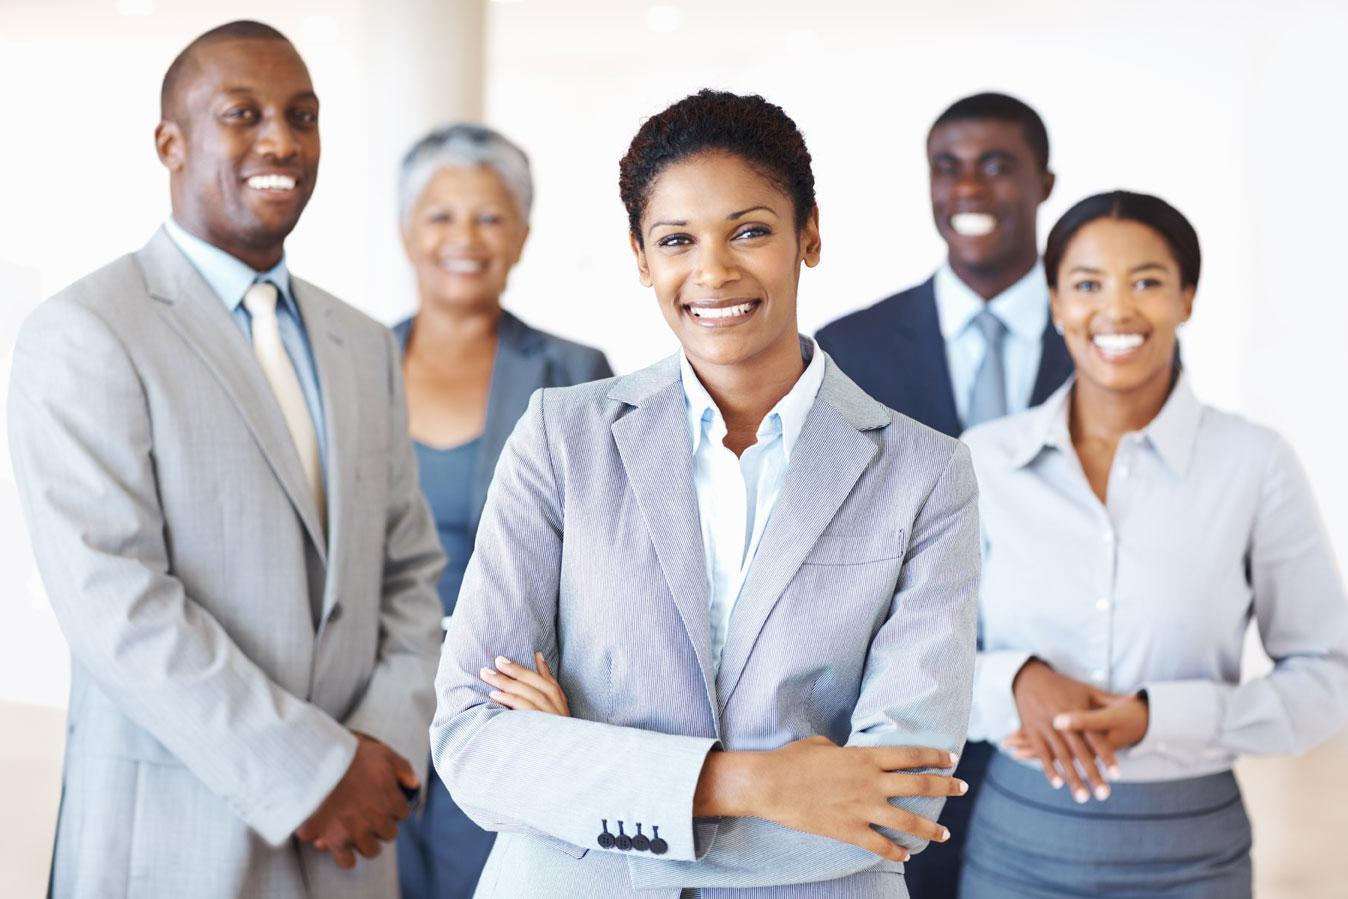

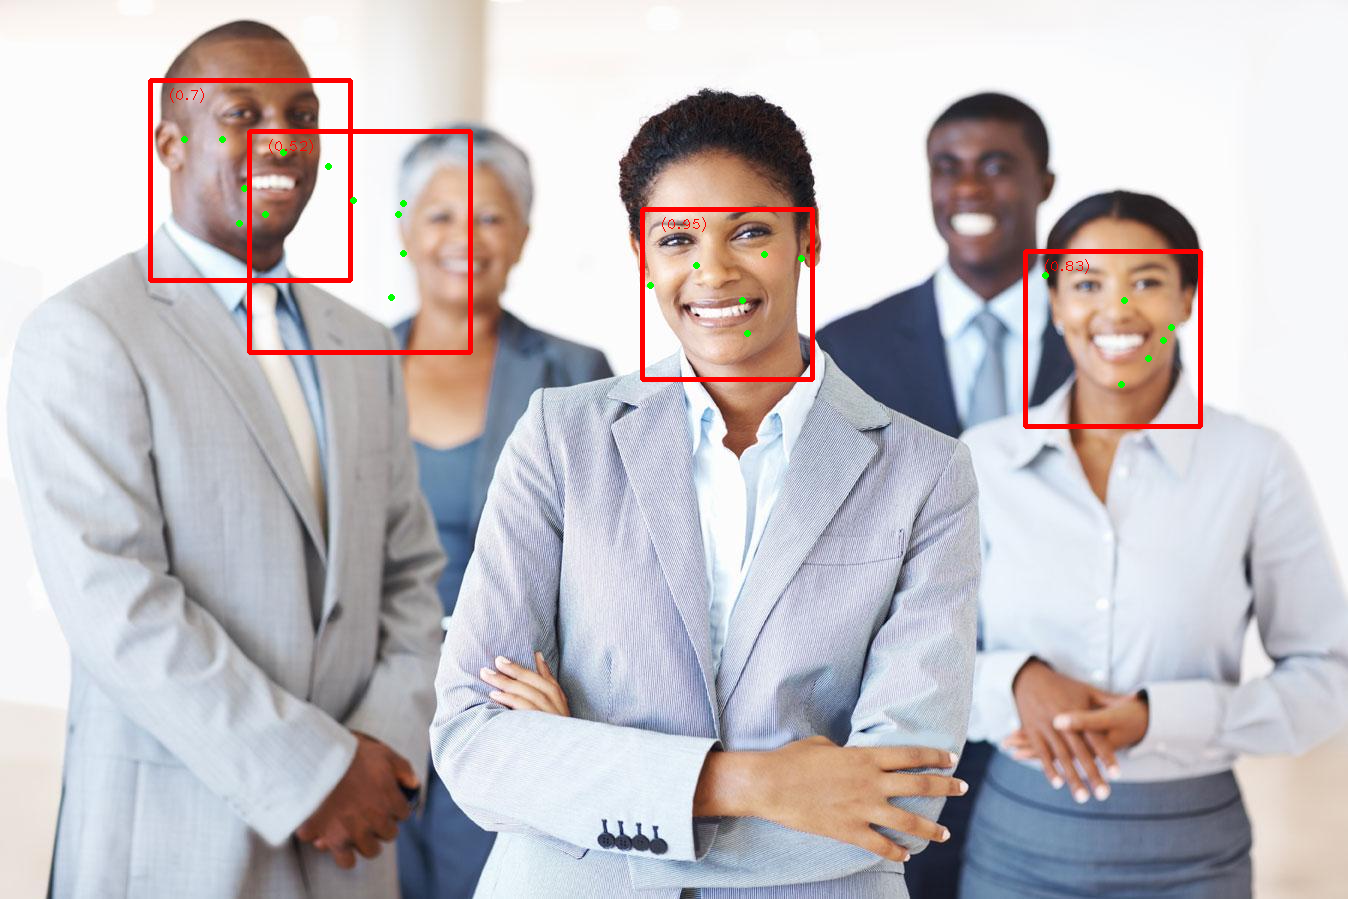

In [55]:
# Загружаем изображение из интернета с помощью curl и сохраняем его в файл 'image.jpg'
!curl https://community.thriveglobal.com/wp-content/uploads/2020/06/black-woman-and-men.jpg -s -o image.jpg

# Задаем имя файла с изображением
IMAGE_FILE = 'image.jpg'

# Читаем изображение с помощью OpenCV и отображаем его (подходит для работы в Google Colab).
import cv2
from google.colab.patches import cv2_imshow

img = cv2.imread(IMAGE_FILE)
cv2_imshow(img)

# STEP 1: Импорт необходимых модулей для работы с изображениями и mediapipe.
import numpy as np
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision

# STEP 2: Создаем объект детектора лиц.
# Указываем путь к модели через базовые опции и создаем объект детектора.
base_options = python.BaseOptions(model_asset_path='detector.tflite')
options = vision.FaceDetectorOptions(base_options=base_options)
detector = vision.FaceDetector.create_from_options(options)

# STEP 3: Загружаем входное изображение для детекции лиц.
image = mp.Image.create_from_file(IMAGE_FILE)

# STEP 4: Выполняем детекцию лиц на изображении.
detection_result = detector.detect(image)

# STEP 5: Обрабатываем и визуализируем результаты детекции.
# Создаем копию изображения, получаем аннотированное изображение с bounding boxes и метками.
image_copy = np.copy(image.numpy_view())
annotated_image = visualize(image_copy, detection_result)

# Преобразуем изображение из формата BGR (используется в OpenCV) в RGB для корректного отображения.
rgb_annotated_image = cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB)
cv2_imshow(rgb_annotated_image)